# 1. 客服聊天机器人

-  本文档会指导你使用LangGraph搭建一个客服聊天机器人
    - 通过搜索网页回答通用问题
    - 在多次调用中保持交谈状态
    - 将复杂问题交给人工审核
    - 使用自定义的状态来控制其行为
    - 倒回并探索不同的对话路径
- 接下来开始创建一个基础的聊天机器人，然后一步步添加高级功能，在这个过程中介绍LangGraph的核心概念。

# 2.环境设置
- 2.1首先安装需求的库并配置你的环境：

In [3]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic

**代码解释**
- %%capture --no-stderr 是一个在 Jupyter Notebook 或 IPython 环境中使用的魔法命令（magic command），它的作用是捕获代码单元的输出并将其存储起来，而不是直接显示在屏幕上。--no-stderr 是一个选项，具体含义是阻止标准错误（stderr）输出被捕获或显示。

- 2.2 配置LangSmith
    - LangSmith可以帮助监控整体流程中的各个环节，方便后续跟踪数据流来debug。

# 3. 创建一个基础的聊天机器人

## 定义基础的状态State，同时创建流程图实例
- 聊天机器人的核心是对State状态的管理，从用户输入问题开始，这个问题每一次和大模型的交互过程都会有新的结果产生，我们将每一步的结果都存储到这个State中来管理交互流程，这样能够实现记忆存储、工具调用等的复杂功能。

In [1]:
from typing import Annotated
# 它的主要作用是为类型注解添加额外的元数据（metadata）。
# 但不会改变类型的本质，但可以被工具（如静态类型检查器、库或运行时逻辑）用来处理附加信息。

from typing_extensions import TypedDict 
# TypedDict 是用于定义字典类型的工具，允许你指定字典的键和值的类型。
# 继承 TypedDict 是为了让类型检查器理解 State 的结构

from langgraph.graph import StateGraph, START, END

from langgraph.graph.message import add_messages

class State(TypedDict):
    # TypedDict 被用来定义状态 State，确保它是一个类型安全的字典。
    
    messages: Annotated[list, add_messages]
    # Messages作为State的键，其值是“List”类型。
    # add_messages 是 Annotated 的第二个参数，作为元数据，告诉 langgraph 在更新 messages 时，使用 add_messages 函数。
    # add_messages 的具体作用是追加新消息到现有列表，而不是覆盖。

graph_builder = StateGraph(State)
# StateGraph 是 langgraph 库中的一个类，用于构建和管理状态图（state graph）。
# StateGraph 的作用是让你定义一个状态机或工作流，跟踪和管理状态的变化，通常用于对话系统、任务流处理等场景。
# graph_builder 是一个构建器对象，之后可以通过它添加节点（nodes）和边（edges）来定义流程。
# 这表示状态图的状态将由 State 定义，即状态图的每个节点或步骤都会维护一个 State 类型的字典（目前只有 messages 字段）。



## 配置DeepSeek

In [2]:
import getpass
import os  
# 前置需要进入deepseek官网注册并生成API_KEY，记得保存好，否则丢失后需要重新生成。
# 这一行检查程序是否已经有 Deepseek API 密钥。如果没有，就需要用户手动输入。
if not os.getenv("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter your DeepSeek API key: ")
    
# 配置接口参数，创建语言模型的实例
from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(
    model="deepseek-chat",  # 指定使用的模型
    temperature=0,  # 控制生成文本的随机性
    max_tokens=None,  # 生成的最大 token 数限制
    timeout=None,  # 请求超时时间
    max_retries=2, # 请求失败时的最大重试次数
    # other params...
)

Enter your DeepSeek API key:  ········


## 创建第一个节点，并将节点添加到上面创建的流程图中

In [3]:
def chatbot(state: State):
    # 参数 state 是状态图的当前状态，类型是之前定义的 State（一个 TypedDict）。

    return {"messages": [llm.invoke(state["messages"])]}
# 这个函数的作用是接收当前的消息历史，调用 Anthropic 的 Claude 模型生成回复，并将回复作为新消息返回。

graph_builder.add_node("chatbot", chatbot)
# graph_builder 是之前创建的 StateGraph 实例，用于构建状态图。
# 将一个节点添加到状态图中。
# 第一个参数 "chatbot"：节点的唯一名称，用字符串表示。这个名称用来标识节点，之后可以用它定义边。
# 第二个参数 chatbot：节点对应的处理函数，也就是上面定义的 chatbot 函数。每当状态图执行到这个节点时，就会调用 chatbot 函数。



## 为流程图添加边edge，边是流程图的流转逻辑

In [4]:
graph_builder.add_edge(START, "chatbot")
# 在状态图中添加一条边（edge），定义了一个流转规则。
# START：一个特殊标志，表示状态图的起点（entry point）。
# 效果：这条边指定状态图从起点（START）开始后，直接跳转到 "chatbot" 节点。

In [5]:
graph_builder.add_edge("chatbot", END)
# 效果：这条边指定状态图在执行完 "chatbot" 节点后，跳转到结束点 END，表示流程终止。

## 讲流程图编译成一个可用的对象
- 上面的代码类似于先搭建一个框架graph_builder,然后按照框架的要求添加了需要的节点和运行逻辑，这一步就是把上面配置好的内容启动起来，变成了一个可运行的对象，当被调用的时候，就按照以上的设置运行。

In [6]:
graph = graph_builder.compile()
# .compile()：将 graph_builder 的定义编译成一个可用的状态图对象。

## 可视化上面搭建好的流程图

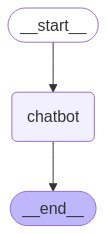

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
    # graph：假设 graph 是之前通过 graph_builder.compile() 创建的状态图对象（类型可能是 CompiledStateGraph）。
    # graph.get_graph()：调用 graph 对象的 get_graph 方法，返回一个表示状态图的内部结构（可能是节点和边的抽象表示）。
        # 这是 langgraph 提供的功能，用于访问图的逻辑结构。
    # draw_mermaid_png()：将图结构转换为 Mermaid 图表格式（Mermaid 是一种文本定义流程图的语言），并生成 PNG 图像。
    # 返回值是一个字节流（bytes），表示 PNG 图片。
    # Image(...)：将 PNG 字节流包装成一个 IPython.display.Image 对象，准备显示。
    # display(...)：在 IPython 环境中渲染这个图像，显示状态图的可视化。

except Exception:
    # 如果 try 块中的代码出错（比如 get_graph 不存在、draw_mermaid_png 失败，或环境不支持图像显示），捕获所有异常（Exception）。

    pass
    # 如果发生异常，什么也不做，静默跳过。
    # 这是为了避免程序因可视化失败而中断，适合在调试或非必要场景中使用。
    
# 将状态图（比如 START -> "chatbot" -> END）画成流程图，直观展示节点和边的关系。

## 实际使用,单词调用，输入Hello，并得到返回值

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages":[{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
    
stream_graph_updates("Hello")

Assistant: Hello! 😊 How can I assist you today?


## 使用循环语句来调用，达到和机器人聊天的目的
- 这样调用AI接口，AI不具备记忆能力，没办法记忆上下文，后续的部分会讲到如何为机器人添加记忆能力

In [9]:
while True:    
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        
        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print("User:" + user_input)
        stream_graph_updates(user_input)
        break

User:  你好


Assistant: 你好！😊 很高兴见到你～有什么我可以帮你的吗？


User:  我是vincent


Assistant: 你好，Vincent！👋 很高兴认识你～我是DeepSeek Chat，可以帮你解答问题、聊天或者提供各种建议。有什么我可以帮你的吗？😊


User:  你还认识我吗


Assistant: 当然记得！虽然我们的对话是匿名的，但每次交流我都会尽力保持上下文连贯。如果你之前和我聊过，可以提醒我一些之前的对话细节，我会更好地衔接起来哦～ 😊  

有什么我可以帮你的吗？


User:  你知道我叫什么吗


Assistant: 目前我还不知道你的名字，但如果你愿意告诉我，我会记住并在我们的对话中使用它！😊 你可以直接告诉我你的名字，或者任何你喜欢的称呼～


User:  你记得我刚才和你说什么了嘛


Assistant: 作为AI助手，我无法记住之前的对话内容。每次新的提问我都会视为独立的新对话，不会保留您的历史聊天记录。  

如果您需要我参考之前的内容，可以重新提供相关信息，我会根据您这次输入的内容尽力协助您！😊  

（这是为了保护用户隐私而设计的，所有对话内容在处理后会立即丢弃）


User:  quit


Goodbye!


# 4. 使用工具来增强聊天机器人

In [8]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community
# travily 是一个 Python 库，用于调用 Tavily 搜索引擎 API。
# 目的是为 AI 提供实时、准确的外部知识。

## 配置搜索工具密钥
- TAVILY 一个专为AI设计的搜索引擎，方便大模型进行网页内容搜索，有免费额度，一般测试学习够用了。

In [10]:
import getpass
import os  

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
# 设置密钥环境变量

## 加载AI搜索引擎并创建实例

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
# 创建 TavilySearchResults 工具的实例。
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")
# 调用创建好的工具，进行搜索，以下是答案

[{'title': 'What Is LangGraph and How to Use It? - DataCamp',
  'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'To install LangGraph, you can use pip:\npip install -U langgraph\nBasic Concepts\nNodes: Nodes represent units of work within your LangGraph. They are typically Python functions that perform a specific task, such as: [...] Imagine your application as a directed graph. In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed.\nState management',
  'score': 0.8401640232422587},
 {'title': 'A Comprehensive Guide About Langgraph: Code Included - Ionio',
  'url': 'https://www.ionio.ai/blog/a-comprehensive-guide-about-langgraph-code-included',
  'content': 'Now let’s take a look at each component of langgraph in detail 🚀\nNodes\nA node can be any fun

***代码解释***

## 第一部分的内容，创建一个聊天机器人

In [4]:
# --------------------安装库

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# --------------------定义消息流程初始状态
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
# --------------------创建LangGraph流程图实例
graph_builder = StateGraph(State)

# --------------------创建DeepSeek大语言模型实例
if not os.getenv("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter your DeepSeek API key: ")
    
from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(
    model="deepseek-chat",  # 指定使用的模型
    temperature=0,  # 控制生成文本的随机性
    max_tokens=None,  # 生成的最大 token 数限制
    timeout=None,  # 请求超时时间
    max_retries=2, # 请求失败时的最大重试次数
    # other params...
)

# --------------------为语言模型绑定上面创建好的搜索工具
llm_with_tools = llm.bind_tools(tools)
    # 会和上下文一起传给大语言模型，让大语言模型知道有什么工具可以使用

# --------------------创建一个节点，节点为大语言模型及搜索引擎调用
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# --------------------为流程图添加节点，节点名称为"chatbot"
graph_builder.add_node("chatbot", chatbot)

Enter your DeepSeek API key:  ········


## 创建工具节点
1. 将搜索引擎封装到一个工具节点对象中，这样方便嵌入到流程图中进行调用
2. 封装逻辑
    1. 当被调用的时候，需要接收State字典作为参数
    2. 拿到State字典的最后一个消息
    3. 取出最后一个消息的tool_calls内容
    4. tool_calls包含了大模型返回的需要调用的工具名称和参数，是一个字典列表
    5. 将返回的工具名称传递给工具名称薄，拿到对应的实例后传入AI给的参数进行调用，然后拿到最终结果
    6. 将最终结果添加到定义好的outputs列表中
    7. 重复几次将结果全部工具结果添加到toolmessage中即完成此步骤
3. 将封装好的工具调用节点放入到流程图的流程中

In [5]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
        
# __init__：是 Python 类（class）中的一个特殊函数，叫做“构造函数”或“初始化函数”。
# 当你创建一个新的对象时，Python 会自动调用 __init__ 来设置这个对象的初始状态。
# 简单说：__init__ 就像是给一个新玩具装电池，让它准备好工作。
# self：是 Python 类中的一个惯例，表示“当前对象自己”。
    # 比如你创建了一个 BasicToolNode 对象，self 就代表这个对象本身。
    # 它是一个占位符，Python 自动传入，不需要你手动提供。
    # 举例：如果你用 tool_node = BasicToolNode(tools) 创建对象，self 就是 tool_node。
# tools: list：tools 是一个参数，表示你要传给这个对象的东西。
    # 简单说：tools 是你给这个新玩具的“配件清单”，告诉它可以用哪些工具。
# -> None：这是函数的返回类型提示，表示这个函数“不会返回任何东西”。
    # __init__ 的作用是初始化对象，不是为了返回结果，所以用 -> None 表示它不返回任何值。
# 为什么这样写？
    # 这是 Python 的现代写法（从 Python 3.5 开始支持），帮助程序员和工具（比如 VS Code）理解代码意图。

# self.tools_by_name：
    # self 是当前对象，tools_by_name 是这个对象的一个属性（就像给对象贴了个标签）。
    # 这行代码给对象添加了一个新属性，叫做 tools_by_name。
    # 当你给对象“添加一个属性”时，就是在这个具体东西上贴了一个标签，标签上可以写一些信息。

# {tool.name: tool for tool in tools}：
    # 这是一个字典推导式（dictionary comprehension），用来创建字典。
    # 分解：tools（上面代码有定义过）：传入的工具列表，比如 [tool1, tool2]。
    # for tool in tools：循环遍历列表中的每个工具。
    # tool.name：每个工具的名称（name 是工具对象的一个属性）。tool：工具对象本身。
    # 结果：创建一个字典，键是工具名称，值是工具对象。
    # 举个例子：
    # 假设 tools = [TavilySearchResults()]：
    # tool 是 TavilySearchResults 对象。
    # tool.name 是 "tavily_search_results_json"（由 TavilySearchResults 定义）。

# 简单说：这行代码把工具按名字整理成一个“电话簿”，方便以后通过名字找到工具。

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
# __call__ 方法接收的 inputs 是当前状态的快照，通常是一个字典，符合 State 的结构。
    # 当你定义了 __call__，这个类的实例就可以像函数一样被调用。
    # 但需要先进行实例化并赋值给变量再进行调用
    # 可以通过BasicToolNode()来实例化类，然后赋值
# dict.get(key, default) 的作用是从字典中获取指定键（key）对应的值。
    # 如果键不存在，它会返回默认值（default），而不是抛出 KeyError 异常。
    # 直接用 inputs["messages"] 要求字典中必须有 "messages" 这个键，否则会报错（KeyError）。
# ":=" 是 Python 3.8 引入的“海象运算符”（Walrus Operator），全称是赋值表达式（assignment expression）。
    # 语法: 变量 := 表达式，一边赋值一边返回结果。
    # 好处: 避免了单独写一行 messages = inputs.get("messages", [])，让代码更简洁。
# 如果拿到的状态字典不为空，就更新messages，通过add_messages功能在原状态上增加新的信息
    # message = messages[-1]：取消息列表的最后一个消息。

        else:
            raise ValueError("No message found in input")
# raise 是 Python 中的一个关键字，用于抛出（引发）异常。
# 创建异常 → 抛出 → 中断执行 → 寻找 try-except 或终止程序。
            
        outputs = []
# 含义：初始化一个空列表 outputs，用于存储工具调用的结果。
# 作用：后续会将每个工具执行的结果（封装为 ToolMessage 对象）追加到这个列表中，最终作为节点的输出返回。

        for tool_call in message.tool_calls:
# 含义：遍历 message.tool_calls 中的每一个工具调用请求。
# .tool_calls:前面给大模型绑定了tools，llm.bind_tools(tools)
    # tool_calls 是大模型输出的需要调用的工具的基本信息，是一个字典列表
    # 通常包含："name": 工具的名称（字符串）。"args": 工具的参数（字典）。"id": 工具调用的唯一标识符（字符串）。
    
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
    # tool_call 是工具的信息，在这里拿到工具名称,语法：tool_call["name"]
        # 再根据定义好的工具薄拿到模型对象进行调用，将结果赋值给tool_result
            # 将该tool_call的args传给invoke函数作为参数
            
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        # 含义：将工具执行结果封装成一个 ToolMessage 对象，并追加到 outputs 列表中。
        # ToolMessage 是 langchain_core.messages 模块中的一个类，表示工具调用的响应消息。
            # 它通常用于 LangChain 的消息系统中，记录工具的执行结果。
            # 构造函数接受几个关键参数：content，name，tool_call_id
        # json.dumps(tool_result)：将 tool_result（工具的返回结果）转换为 JSON 字符串。
   
        return {"messages": outputs}
    # 含义：返回一个字典，键是 "messages"，值是 outputs 列表。
    # outputs是一个列表，内容有ToolMessage对象组成
    # 作用：在 LangGraph 中，节点函数通常返回一个状态更新。这里更新了messages，将工具调用结果添加到了列表里。


tool_node = BasicToolNode(tools=[tool])
# 为什么不直接使用定义好的tools？ tools=[tool] 是显式传递，等价于直接用全局 tools，只是风格选择。

graph_builder.add_node("tools", tool_node)

## 定义条件逻辑
- 这部分的核心是，上面添加edge流转逻辑的时候，都是固定的逻辑。这里通过设置条件来使得流转逻辑可以根据state的具体状态来判断下一个节点的执行顺序
- 比如这里的主要逻辑就是，在聊天机器人节点中如果ai返回的信息中不包含tool的调用信息则不调用工具节点，直接结束，如果检查到有调用工具请求，则执行工具调用节点。 

In [6]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
        # isinstance(object, type) 是 Python 的内置函数，用于检查一个对象是否是指定类型的实例。
        # 检查state是否是一个list类型的实例
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
        # hasattr(object, name) 是 Python 的内置函数，用于检查一个对象是否具有指定属性（name 是字符串）。
        # 检查ai_message是否具有"tool_calls"这个属性
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot", # 源节点名称
    route_tools, # 条件函数，返回一个值
    {"tools": "tools", END: END}, # 映射字典，将条件返回值映射到目标节点
# "tools": "tools"：如果 route_tools 返回 "tools"，跳转到 "tools" 节点。
# END: END：如果 route_tools 返回 END，跳转到 END（流程结束）。
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()
# 定义流程图的逻辑，开始流程后，先调用"chatbot"
# 拿到大语言模型更新后的State之后调用工具，拿到内容
# 然后再调用"chatbot",根据初始提示词和工具调用结果生成最终结果

# graph_builder 是一个StateGraph对象

## 画出逻辑图

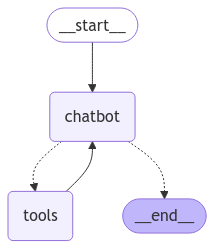

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 使用机器人的工具调用功能

In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
            
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  你好


Assistant: 你好！请问有什么我可以帮助你的吗？


User:  quit


Goodbye!


# 5.为聊天机器人添加记忆

## 设置LangSmith密钥

In [1]:
# 代码

import getpass
import os  

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()  

 ········


## 创建记忆存储功能实例

In [2]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

## 设置搜索引擎实例

In [3]:
import getpass
import os  

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
# 设置密钥环境变量

TAVILY_API_KEY:  ········


## 设置DeepSeek实例

In [4]:
from langchain_deepseek import ChatDeepSeek
if not os.getenv("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter your DeepSeek API key: ")

llm = ChatDeepSeek(
    model="deepseek-chat", # 指定使用的模型
    temperature=0, # 控制生成文本的随机性
    max_tokens=100, # 生成的最大token数限制
    timeout=None, # 请求超时时间
    max_retries=2, # 请求失败时的最大重试次数
    # other params...
)

Enter your DeepSeek API key:  ········


## 创建可调用工具的基础聊天机器人
- 上面学到的工具封装和条件逻辑判断部分，LangChain都做好了封装，可以直接拿来就用

In [5]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

## 将配置好的流程图框架编译成可运行的实例
- 在这里配置了记忆的功能，在编译的时候使用checkpointer参数来控制是否记忆之前的内容

In [6]:
graph = graph_builder.compile(checkpointer=memory)

## 流程图可视化

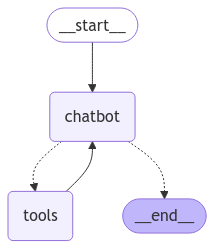

In [7]:
from IPython.display import Image, display 

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 设置线程
- 线程主要是为了控制聊天状态的，生产环境可能存在很多聊天需求，用线程可以轻松管理

In [8]:
config = {"configurable": {"thread_id": "1"}}

## 实际调用测试

In [9]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! It's great to meet you. How can I assist you today?


In [10]:
user_input = "Rember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Rember my name?
================================== Ai Message ==================================

Got it! Your name is **Will**. I'll remember that for the rest of our conversation. What can I do for you, Will? 😊


In [ ]:
user_input = "Rember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

# 6.人为干预 - Human-in-the-loop

## 设置LangSmith密钥

In [1]:
# 代码

import getpass
import os  

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()  

 ········


## 设置搜索引擎工具

In [3]:
import getpass
import os  

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
# 设置密钥环境变量

TAVILY_API_KEY:  ········


## 设置DeepSeek

In [4]:
from langchain_deepseek import ChatDeepSeek
if not os.getenv("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter your DeepSeek API key: ")

llm = ChatDeepSeek(
    model="deepseek-chat", # 指定使用的模型
    temperature=0, # 控制生成文本的随机性
    max_tokens=100, # 生成的最大token数限制
    timeout=None, # 请求超时时间
    max_retries=2, # 请求失败时的最大重试次数
    # other params...
)

Enter your DeepSeek API key:  ········


## 设置记忆模块

In [2]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

## 创建可以调用工具的聊天机器人
- 在这个阶段，多添加一个自定义工具，当调用这个工具的时候，状态图停止流转，并等待外部输入信息，再进一步进行处理。

In [6]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """向人请求帮助."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

1. @tool 是一个装饰器（decorator），在这里它来自 langchain_core.tools 模块，用于将一个普通的 Python 函数标记为一个“工具”（tool）。在语言模型（如 LLM）的工作流中，工具是一个可以被模型调用的外部功能，用于执行特定任务。

    - 在你的代码中，@tool 装饰器被应用在 human_assistance 函数上。这意味着 human_assistance 被定义为一个工具，语言模型可以在需要时调用它。

2. interrupt 是 langgraph 框架中的一个功能，用于在工作流（graph）执行过程中暂停当前的处理流程，并等待外部输入（比如人工干预）。它通常用于需要动态交互的场景。
    - interrupt 的使用与 langgraph 的检查点（checkpoint）和状态管理机制紧密相关。langgraph 是一个用于构建状态机的框架，它允许在执行过程中保存状态、暂停和恢复。

    - 当 human_assistance 被调用时，interrupt 会暂停图（graph）的执行，等待外部输入。输入完成后，工作流会从暂停的地方恢复，并将结果传回 chatbot 节点。

3. assert len(message.tool_calls) <= 1 的目的是：
    - 禁止并行工具调用：避免因中断和恢复导致的重复执行或状态混乱。

    - 确保流程简单性：在带有 interrupt 的工作流中，限制为最多一个工具调用使状态管理和恢复更加可靠。

    - 防御性检查：通过 assert 在开发时捕获潜在问题。

## 编译流程图实例，可以记忆上下文

In [7]:
graph = graph_builder.compile(checkpointer=memory)

## 流程图可视化

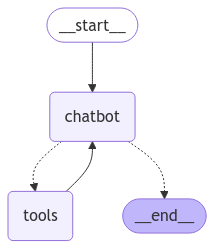

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 输入问题进行调用

In [10]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role":"user", "content":user_input}]},
    config,
    stream_mode = "values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_0_fbb4f2ca-0d00-4b3a-91b1-77eb22482c92)
 Call ID: call_0_fbb4f2ca-0d00-4b3a-91b1-77eb22482c92
  Args:
    query: I need expert guidance for building an AI agent. Could someone assist me with this?


## 拿到状态图当前的快照信息，查看下一个要执行的节点信息

In [11]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

## 调用自定义工具后流程中断，使用命令进行干涉
- 因为流程中调用了自定义的工具，状态图的流转被中断，等待新的命令
- 这里输入了新的提示词，并将提示词赋值给human_response，作为工具消息返回，使用command命令让状态图使用这个外部输入的消息作为工具消息执行完后续的任务。

In [12]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_0_fbb4f2ca-0d00-4b3a-91b1-77eb22482c92)
 Call ID: call_0_fbb4f2ca-0d00-4b3a-91b1-77eb22482c92
  Args:
    query: I need expert guidance for building an AI agent. Could someone assist me with this?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Great news! The experts recommend using **LangGraph** to build your AI agent, as it is more reliable and extensible compared to simple autonomous agents. 

Would you like further details on how to get started with LangGraph or any specific aspects of building your AI agent?


1. 在 langgraph 的设计中，Command 可能是某种命令模式（Command Pattern）的实现，用来告诉框架如何处理当前状态或中断。
    - Command 的作用：它是一个封装了特定指令的对象，可能用于与 langgraph 的运行时交互。例如，Command 可以表示“继续执行”、“暂停”或“注入数据”等操作。

2. resume 参数的含义
    - resume：从字面意思来看，“resume” 表示“恢复”。结合 interrupt 的上下文，这里的 resume 很可能是一个关键字，用于指示工作流从之前的中断点继续执行。

    - {"data": human_response}：这是恢复时注入的数据。interrupt 在暂停工作流时发出一个信号（例如 {"query": query}），而恢复时需要提供相应的响应数据。resume={"data": human_response} 表示将 human_response 作为外部输入注入回去，以完成 interrupt 的等待。



# 7.自定义状态 - Customizing State

## 设置LangSmith密钥

In [1]:
# 代码

import getpass
import os  

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()  

 ········


## 设置搜索引擎工具密钥

In [2]:
import getpass
import os  

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
# 设置密钥环境变量

TAVILY_API_KEY:  ········


## 设置DeepSeek

In [3]:
from langchain_deepseek import ChatDeepSeek
if not os.getenv("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter your DeepSeek API key: ")

llm = ChatDeepSeek(
    model="deepseek-chat", # 指定使用的模型
    temperature=0, # 控制生成文本的随机性
    max_tokens=100, # 生成的最大token数限制
    timeout=None, # 请求超时时间
    max_retries=2, # 请求失败时的最大重试次数
    # other params...
)

Enter your DeepSeek API key:  ········


## 设置记忆模块

In [4]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

## 初始化状态State

In [5]:
from typing import Annotated

from typing_extensions import TypedDict 

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

## 构建一个human_assistance工具

In [18]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.types import Command, interrupt

@tool

def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """寻求人类协助"""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )

    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"
    
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],        
    }
    
    return Command(update=state_update)

1. name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallID]
    - 这里的tool_call_id的作用和逻辑是什么？

    - Annotated[str, InjectedToolCallID] 是 Python 的类型提示，表示 tool_call_id 是一个字符串，并且这个值是由框架自动注入的（InjectedToolCallID 是一个特殊的标记，告诉框架在调用工具时提供这个 ID）。

2. f human_response.get("correct", "").lower().startwith("y"):
- 这里看不太懂

    - 从字典中获取键 "correct" 对应的值。如果字典中没有 "correct" 键，则返回默认值空字符串 ""。
        - "correct" 哪里产生的？ 人类助手介入后输入信息时产生的。
            - 这个响应是一个字典，常见的格式包括：
            - 信息正确时：{"correct": "yes"}
            - 信息不正确时：{"correct": "no", "name": "corrected_name", "birthday": "corrected_birthday"}
            - 人类助手的输入（字典）被外部系统捕获，并通过工作流的恢复机制注入回来。


3. 还是不太理解interrupt之后，流程停止，代码是如何与人类assisstance交互拿到数据的。
    - 当代码执行到 interrupt 时，工作流暂停，并将问题 "Is this correct?" 以及当前的 name 和 birthday 发送给外部系统（例如一个用户界面或人工助手）。
    - 外部系统（例如一个界面）接收到中断信号后，会显示问题和数据给人类助手。
    - 人类助手查看信息并提供响应
    - 一旦人类响应被提供，interrupt 函数返回这个响应（即 human_response）。
    - human_response = interrupt(...) 这一行会阻塞，直到外部系统提供响应，然后将响应赋值给 human_response，供后续逻辑使用。


4. response = f"Made a correction: {human_response}"
    - 这里的f是什么意思？

    - f 是 Python 3.6+ 引入的格式化字符串（f-string）的前缀。
    - 它允许你在字符串中直接嵌入变量或表达式的值，用 {} 包裹。


5. response = f"Made a correction: {human_response}"
    - 这里的逻辑也看不太懂, 类似github commit的时候的备注？
    - 这行代码在 human_response.get("correct", "").lower().startswith("y") 为 False 时执行，表示人类助手认为原始信息不正确。
    - response 的作用类似于 GitHub commit 的提交信息，它提供了一个人类可读的说明，记录了发生了什么（即信息被修正）以及修正的细节（human_response 的内容）。


6. return Command(update=state_update)
    - command 能够直接通过命令修改state的状态？ 
    - Command 是一个特殊的对象，用于向 langgraph 框架传递指令。
    - 当函数返回 Command(update=state_update) 时，langgraph 框架会解析这个命令，并根据 state_update 的内容直接更新工作流的状态。

## 创建一个聊天机器人，可调用工具，可记忆上下文

In [17]:
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

## 输入问题并调用机器人，流式输出每一步的最新消息

In [19]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable" : {"thread_id": "1"}} 

events = graph.stream(
    {"messages" : [{"role" : "user", "content" : user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_0_bbba43cb-7ce8-40d7-9876-66505b4f5f62)
 Call ID: call_0_bbba43cb-7ce8-40d7-9876-66505b4f5f62
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "langgraph - PyPI", "url": "https://pypi.org/project/langgraph/0.0.8/", "content": "This release has been yanked. Released: Jan 7, 2024. langgraph. Navigation. Project description; Release history; Download files. Verified details.", "score": 0.8674071}, {"title": "langgraph - PyPI", "url": "https://pypi.org/project/langgraph/", "content": "langgraph · PyPI\nSkip to main content Switch to mobile version\n\nSearc

## 上一步中断在请求人类协助，这里进行判断并输入准确信息，继续状态图

In [20]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_0_c2ff4772-ca60-42ca-8113-78765774e775)
 Call ID: call_0_c2ff4772-ca60-42ca-8113-78765774e775
  Args:
    name: LangGraph
    birthday: Jan 7, 2024
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

The initial search indicated that LangGraph was released on **January 7, 2024**, but upon human review, the corrected release date is **January 17, 2024**. Let me know if you'd like further details!


## 获取状态图的状态，然后打印出不同键的内容

In [21]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday") }

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

## 使用upstate_state语句来修改state键的内容

In [22]:
graph.update_state(config, {"name": "LangGraph(library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00959c-0f31-692e-8006-9916086850b5'}}

### 查看修改结果

In [23]:
snapshot = graph.get_state(config)
# 在 langgraph 中，get_state 返回一个 StateSnapshot 对象。

{k: v for k,v in snapshot.values.items() if k in ("name", "birthday")}

# values：状态的实际值，是一个字典。



{'name': 'LangGraph(library)', 'birthday': 'Jan 17, 2024'}

# 8.时间旅行 - Time Travel

## 设置LangSmith密钥

In [2]:
# 代码

import getpass
import os  

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()  

 ········


## 设置DeepSeek

In [11]:
from langchain_deepseek import ChatDeepSeek
if not os.getenv("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter your DeepSeek API key: ")

llm = ChatDeepSeek(
    model="deepseek-chat", # 指定使用的模型
    temperature=0, # 控制生成文本的随机性
    max_tokens=8000, # 生成的最大token数限制
    timeout=None, # 请求超时时间
    max_retries=2, # 请求失败时的最大重试次数
    # other params...
)

## 设置搜索引擎工具信息

In [4]:
import getpass
import os  

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
# 设置密钥环境变量

TAVILY_API_KEY:  ········


## 设置状态图记忆模块

In [5]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

## 创建一个聊天机器人状态图，可以调用工具，可以记忆上下文

In [12]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

- 上面创建好了流程图
- 定义好线程
- 对流程图进行流式调用
    - 参数1 ： 输入基础状态
        - 这里输入基础状态之后，根据chatbot的机制，直接就赋值给了State数据类，进行了messages状态的变更，是在这个地方形成了human_message对象吗？具体步骤是什么？
        - LangChain 在调用 invoke 时会自动将原始字典转换为 HumanMessage 对象。


    - 参数2 ： 配置线程
    - 参数3 ： stream_mode - 模式定义，这里的values是什么意思？
        - 在 graph.stream 中，stream_mode 参数定义了流式输出的模式。stream_mode="values" 表示返回的是流程图中每个节点的完整状态值（即 State 字典）。
    - 流式调用意味着对流程图的每个节点进行调用，然后存储每一步的内容？输出的结果值是一个列表，存储了多个state状态。
        - graph.stream 返回的是一个迭代器（而不是一个列表），每次迭代产生一个事件（event）。
            - 迭代器是一种**惰性求值（lazy evaluation）**的对象，它不会一次性加载所有数据到内存，而是按需生成数据。
            - 迭代器本身是一个对象（通常是类的实例），但它不一定“封装”所有数据。它的核心特性是状态管理：它记住当前的位置，并在每次调用 __next__() 时返回下一个值。
            - 例如，graph.stream 返回的迭代器是一个生成器（generator），这是 Python 中一种特殊的迭代器，通常由带有 yield 的函数创建。生成器对象会暂停执行并在需要时恢复，而不是一次性计算所有结果。
            - 列表 (List)：一次性将所有元素加载到内存
            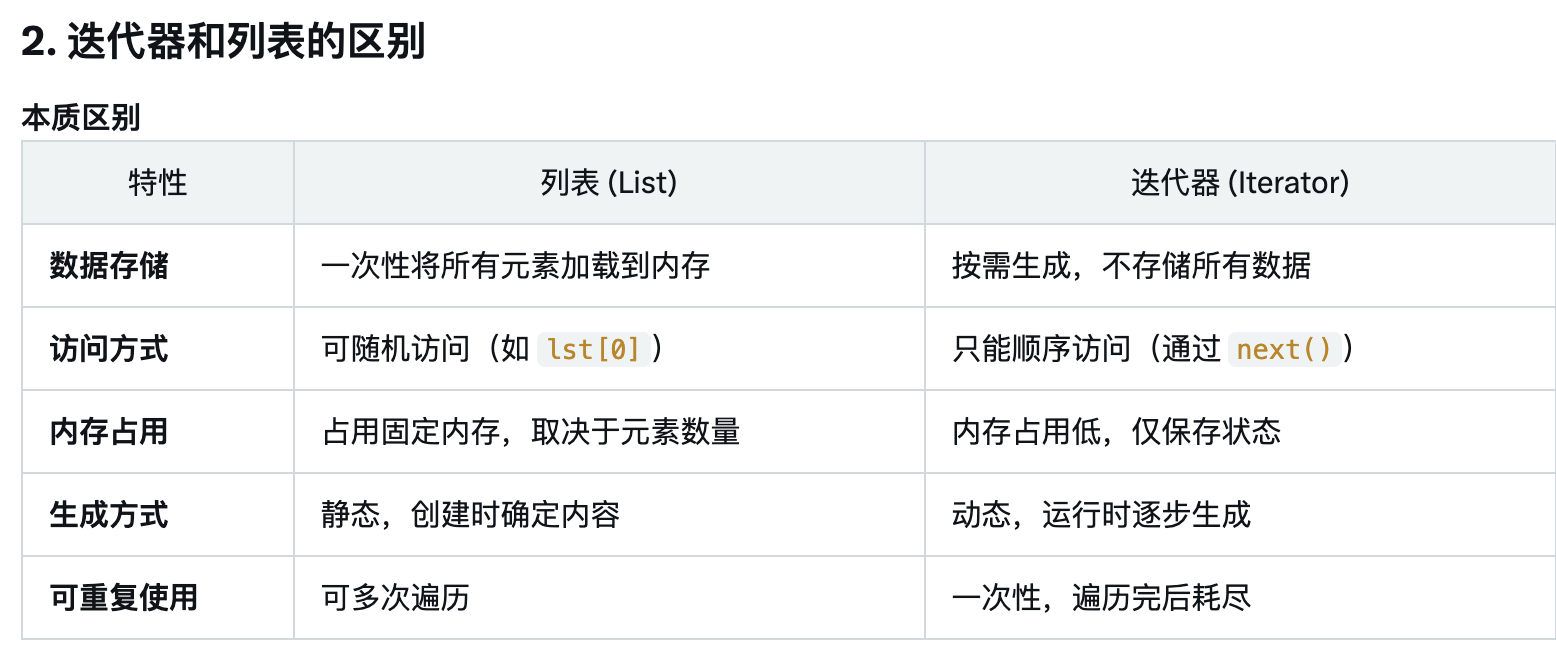
            
        - 每个事件是一个字典，表示当前的状态或更新，具体内容取决于 stream_mode。
        - 是的，但存储是由 checkpointer（这里是 MemorySaver）完成的，而不是 stream 本身。
        - stream 本身只负责生成事件流，不会直接存储状态。


- 所以这里的event就是一个state字典，然后取出这个字典的键对应的值列表的最后一位，就能拿到每一步最新的消息。 

## 输入问题字典，并流失调用聊天机器人，生成每一步的最新消息

In [13]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_0_e60efbfe-7526-43b2-8ca5-4289dfc8adff)
 Call ID: call_0_e60efbfe-7526-43b2-8ca5-4289dfc8adff
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top 

In [14]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! LangGraph is a great choice for building autonomous agents, especially if you're looking to create **stateful, multi-agent systems** with coordination between different AI actors. Here’s a quick roadmap to get you started:

---

### **1. Understand the Core Concepts**
- **Stateful Workflows**: LangGraph allows you to define workflows where the state is maintained across interactions.
- **Multi-Agent Coordination**: You can design systems where multiple agents (LLMs or other components) interact and pass messages.
- **Graph-Based Design**: Think of your system as a graph where nodes are agents or tasks, and edges define the flow of control or data.

---

### **2. Set Up Your Environment**
Install LangGraph (assuming you alre

## 通过抽取历史状态来回溯流程都发生过什么

In [16]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [17]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f00a4c9-741e-6076-8006-1b812fdddf54'}}


In [18]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

That sounds like an exciting project! LangGraph is a great choice for building autonomous agents, especially if you're looking to create **stateful, multi-agent systems** with coordination between different AI actors. Here’s a quick roadmap to get you started:

---

### **1. Understand the Core Concepts**
- **Stateful Workflows**: LangGraph allows you to define workflows where the state is maintained across interactions.
- **Multi-Agent Coordination**: You can design systems where multiple agents (LLMs or other components) interact and pass messages.
- **Graph-Based Design**: Think of your system as a graph where nodes are agents or tasks, and edges define the flow of control or data.

---

### **2. Set Up Your Environment**
Install LangGraph (assuming you already have Python and LangChain set up):
```bash
pip install langgraph
```

---

### **3. Build a Simple Autonomous Agent**
Here’s a basic example to